In [3]:
import os, sys
import numpy as np
import healpy as hp
import pandas as pd
import h5py
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

os.system('module load texlive/2022')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times",
    "font.size"  : 13
})

matplotlib.rcParams.update({'font.size': 15})

matplotlib.rcParams['mathtext.fontset'] = 'stix'
plt.rc('text.latex', preamble=r'\usepackage{/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/apjfonts}')
        
#plt.rcParams["font.family"] = "Times New Roman"

plt.rcParams['axes.facecolor']   = 'w'
plt.rcParams['figure.facecolor'] = 'w'


kidscol = '#9CC363'    # light olive
descol  = 'chocolate'  # dark orange
hsccol  = '#5A8BAF'    # lightpurple

In [ ]:
plt.plot(np.arange(19))

# Footprint

In [ ]:
1+1

# Figure 1

# Various distributions

In [6]:
# Figure 2 shows various quantities of the shear catalogs post-processing.

# catalogs can be found here at NERSC:
desy3path = '/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/des-y3/shear_catalog_desy3_unmasked_withfakez_v2.h5'
hscy3path = '/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/hsc-y3/shear/txpipe_allfield_shear.h5'
kidspath  = '/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/kids/shear_catalog_kids1000.hdf5'

# We run TXPipe's SourceSelector
# and load the processed catalogs

with h5py.File('../TXPipe/data/desy3/outputs/shear_tomography_catalog.hdf5','r') as f:
    source_bin = f["tomography/bin"][:]
    mask = source_bin != -1
    R_total_2d = f["response/R_S_2d"][:] + f["response/R_gamma_mean_2d"][:]
    with h5py.File(desy3path,'r') as g:
        h = g['shear']
        des_g1   = h["mcal_g1"][:][mask] 
        des_g2   = h["mcal_g1"][:][mask]
        des_psfT = h["mcal_psf_T_mean"][:][mask]
        des_T    = h["mcal_T"][:][mask]
        des_snr  = h["mcal_s2n"][:][mask]
        # calibrate:
        des_g1,des_g2 = np.linalg.inv(R_total_2d) @ [des_g1,des_g2]

with h5py.File('../TXPipe/data/hsc-y3/outputs/shearsys/shear_tomography_catalog.hdf5','r') as f:
    source_bin = f["tomography/bin"][:]
    mask = source_bin != -1  
    R = f['response/R_mean_2d'][0]
    K = f['response/K_2d'][0]
    with h5py.File(hscy3path,'r') as g: 
        h = g['shear']
        hsc_g1   = h['g1'][:][mask]
        hsc_g2   = h['g2'][:][mask]
        hsc_psfT = h['psf_T_mean'][:][mask]
        hsc_T    = h['T'][:][mask]
        hsc_snr  = h['s2n'][:][mask]
        # calibrate:
        hsc_g1 = ((hsc_g1 / (2 * R) - h['c1'][:][mask]) / (1 + K) - h['aselepsf1'][:][mask])/(1+h['msel'][:][mask])
        hsc_g2 = ((hsc_g2 / (2 * R) - h['c2'][:][mask]) / (1 + K) - h['aselepsf2'][:][mask])/(1+h['msel'][:][mask])

with h5py.File('../TXPipe/data/kids/outputs/meansubperfield/shear_tomography_catalog.hdf5','r') as f:
    source_bin = f["tomography/bin"][:]
    mask = source_bin != -1
    c_n = f["response/C_2d_N"][:] 
    c_s = f["response/C_2d_S"][:]
    K   = f["response/K_2d"][:] 
    with h5py.File(kidspath,'r') as g:
        h = g['shear']
        kids_g1   = h['g1'][:][mask]
        kids_g2   = h['g2'][:][mask]
        kids_psfT = h['psf_T_mean'][:][mask]
        kids_T    = h['T'][:][mask]
        kids_snr  = h['s2n'][:][mask]
        # additive bias removal:
        Nmask = h['dec'][:][mask] > -25.0
        Smask = h['dec'][:][mask] <= -25.0

        kids_g1[Nmask] = (kids_g1[Nmask] - c_n[0]) / (1 + K)
        kids_g1[Smask] = (kids_g1[Smask] - c_s[0]) / (1 + K)
        kids_g2[Nmask] = (kids_g2[Nmask] - c_n[1]) / (1 + K)
        kids_g2[Smask] = (kids_g2[Smask] - c_s[1]) / (1 + K)
        

<Figure size 640x480 with 0 Axes>

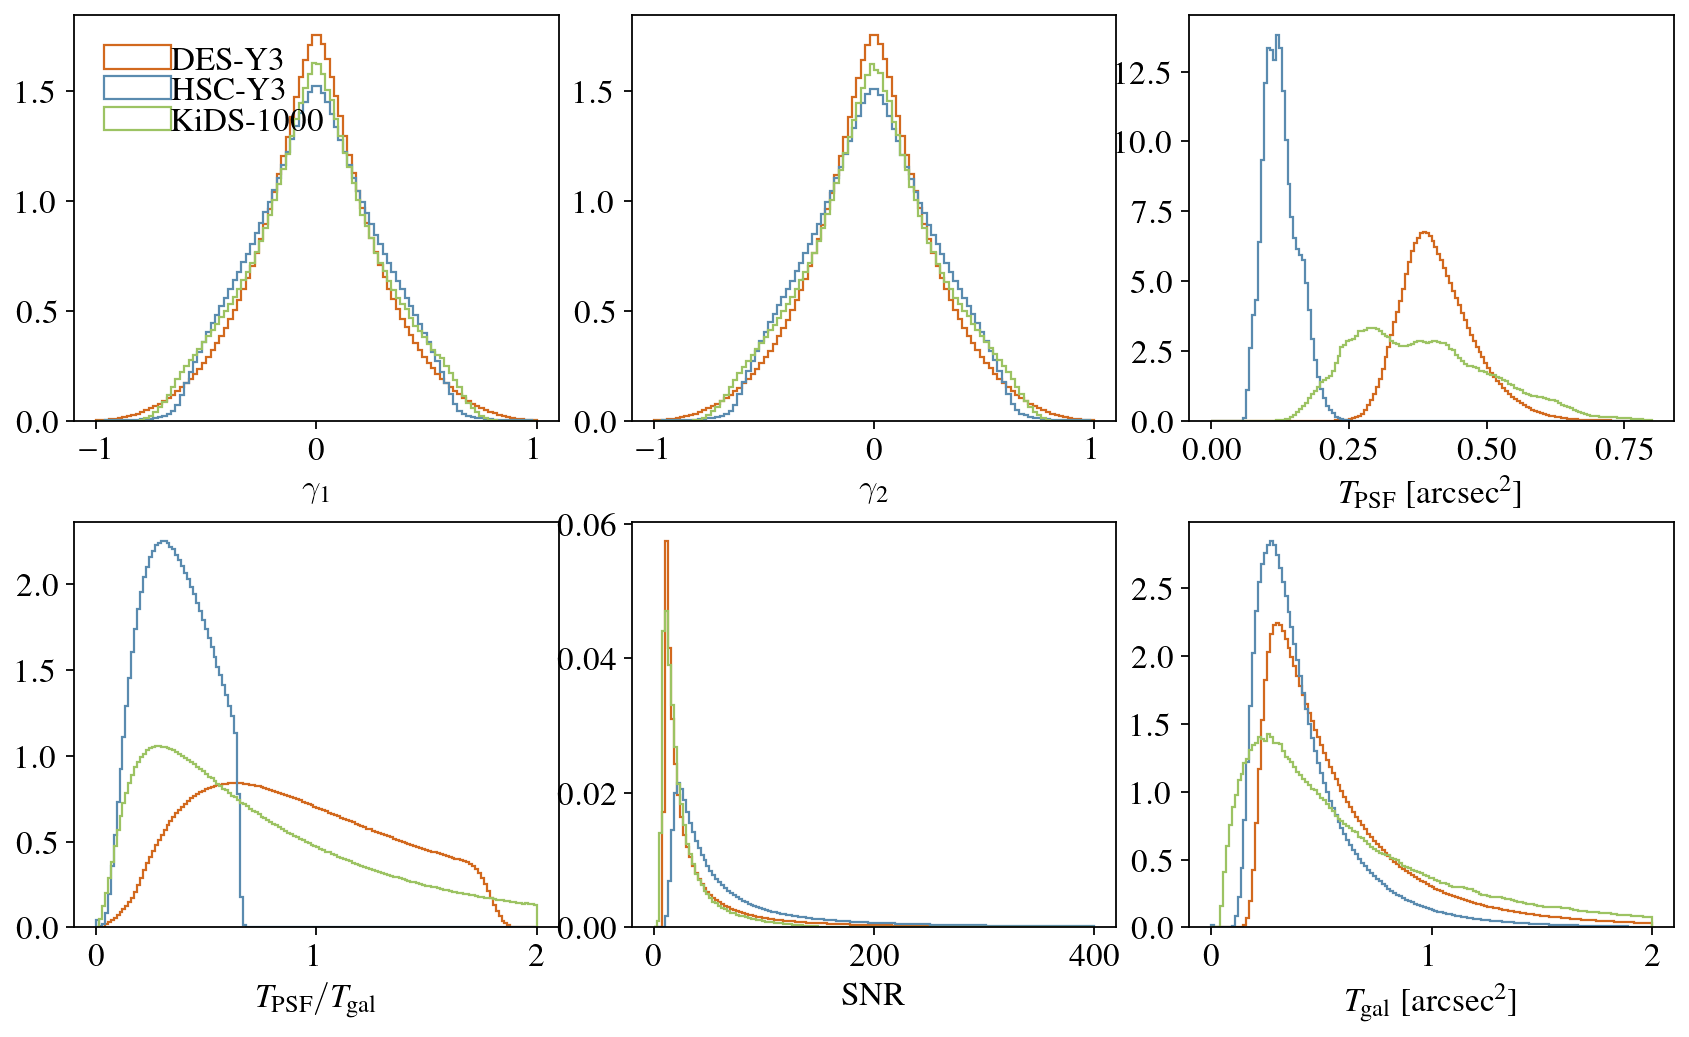

In [8]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

matplotlib.rcParams.update({'font.size': 15})

plt.clf()
fig = plt.figure(figsize=(10,6),dpi=80)
gs  = gridspec.GridSpec(2, 3, top=0.95, right=1.00, left=0.00, bottom=0.00,hspace=0.25,wspace=0.15)
ax0 = plt.subplot(gs[0])
ax0.hist(des_g1,bins=100,range=[-1,1],label='DES-Y3',histtype='step',color=descol,density=True)
ax0.hist(hsc_g1,bins=100,range=[-1,1],label='HSC-Y3',histtype='step',color=hsccol,density=True)
ax0.hist(kids_g1,bins=100,range=[-1,1],label='KiDS-1000',histtype='step',color=kidscol,density=True)
ax0.set_xlabel(r'$\gamma_{1}$')
ax0.legend(frameon=False,loc = 'upper left', labelspacing=0.00,ncol=1,handletextpad=0.0,columnspacing=0.2)

ax1 = plt.subplot(gs[1])
ax1.hist(des_g2,bins=100,range=[-1,1],label='DES-Y3',histtype='step',color=descol,density=True)
ax1.hist(hsc_g2,bins=100,range=[-1,1],label='HSC-Y3',histtype='step',color=hsccol,density=True)
ax1.hist(kids_g2,bins=100,range=[-1,1],label='KiDS-1000',histtype='step',color=kidscol,density=True)
ax1.set_xlabel(r'$\gamma_{2}$')

ax2 = plt.subplot(gs[2])
ax2.hist(des_psfT,bins=150,range=[0,0.8],label='DES-Y3',histtype='step',color=descol,density=True)
ax2.hist(hsc_psfT,bins=150,range=[0,0.8],label='HSC-Y3',histtype='step',color=hsccol,density=True)
ax2.hist(kids_psfT,bins=150,range=[0,0.8],label='KiDS-1000',histtype='step',color=kidscol,density=True)
ax2.set_xlabel(r'$T_{\rm PSF}\ [{\rm arcsec}^{2}]$')

ax3 = plt.subplot(gs[3])
ax3.hist(des_psfT/des_T,bins=150,range=[0,2],label='DES-Y3',histtype='step',color=descol,density=True)
ax3.hist(hsc_psfT/hsc_T,bins=150,range=[0,2],label='HSC-Y3',histtype='step',color=hsccol,density=True)
ax3.hist(kids_psfT/kids_T,bins=150,range=[0,2],label='KiDS-1000',histtype='step',color=kidscol,density=True)
ax3.set_xlabel(r'$T_{\rm PSF}/T_{\rm gal}$')

ax4 = plt.subplot(gs[4])
ax4.hist(des_snr,bins=150,range=[0,400],label='DES-Y3',histtype='step',color=descol,density=True)
ax4.hist(hsc_snr,bins=150,range=[0,400],label='HSC-Y3',histtype='step',color=hsccol,density=True)
ax4.hist(kids_snr,bins=150,range=[0,400],label='KiDS-1000',histtype='step',color=kidscol,density=True)
ax4.set_xlabel(r'${\rm SNR}$')

ax5 = plt.subplot(gs[5])
ax5.hist(des_T,bins=150,range=[0,2],label='DES-Y3',histtype='step',color=descol,density=True)
ax5.hist(hsc_T,bins=150,range=[0,2],label='HSC-Y3',histtype='step',color=hsccol,density=True)
ax5.hist(kids_T,bins=150,range=[0,2],label='KiDS-1000',histtype='step',color=kidscol,density=True)
ax5.set_xlabel(r'$T_{\rm gal}\ [{\rm arcsec}^{2}]$')

#plt.savefig('shear_histograms.pdf',bbox_inches='tight')

# PSF distribution

In [10]:
# PSF catalogs for each survey can be found here at NERSC:
desy3_s = h5py.File('/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/des-y3/DES_psf_y3_catalog.hdf5','r')
hscy3_s = h5py.File('/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/hsc-y3/star/catalog/txpipe_allfield_star_nosnrcut.h5','r')
kids_s = h5py.File('/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/kids/kids1000_psf_catalog.h5','r')

<Figure size 640x480 with 0 Axes>

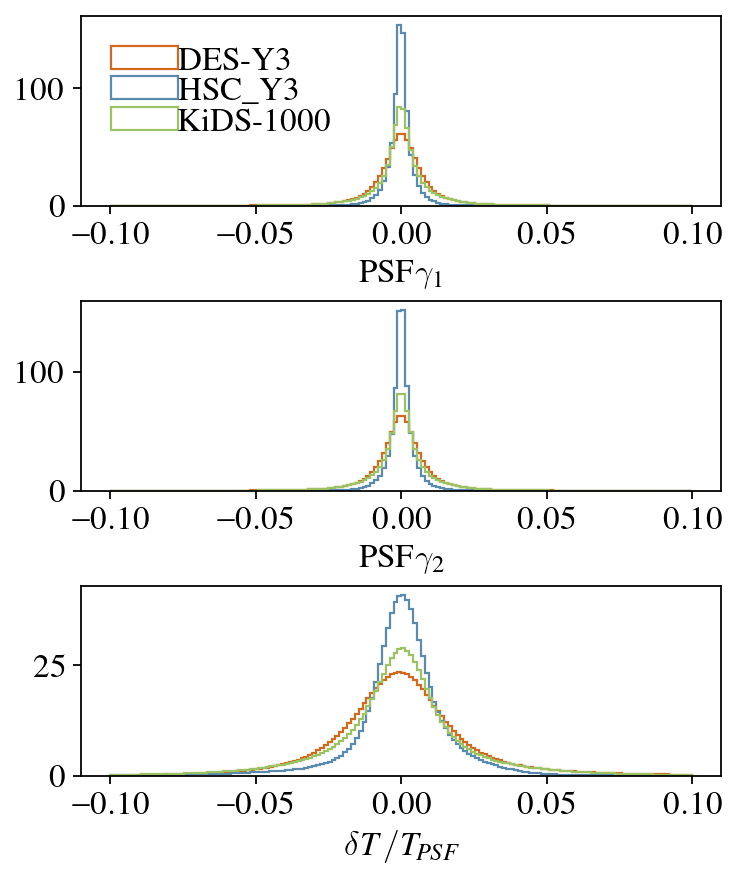

In [12]:
%matplotlib inline

matplotlib.rcParams.update({'font.size': 15})

plt.clf()
fig = plt.figure(figsize=(4,5),dpi=80)
gs  = gridspec.GridSpec(3, 1, top=0.95, right=1.00, left=0.00, bottom=0.00,hspace=0.5,wspace=0.15)

ax0 = plt.subplot(gs[0])
ax0.hist((desy3_s['stars/measured_e1'][:]- desy3_s['stars/model_e1'][:]),bins=150,range=[-0.1,0.1],histtype='step',color=descol,label='DES-Y3',density=True)
ax0.hist((hscy3_s['stars/measured_e1'][:]- hscy3_s['stars/model_e1'][:]),bins=150,range=[-0.1,0.1],histtype='step',color=hsccol,label='HSC_Y3',density=True)
ax0.hist((kids_s['stars/measured_e1'][:]- kids_s['stars/model_e1'][:]),bins=150,range=[-0.1,0.1],histtype='step',color=kidscol,label='KiDS-1000',density=True)
ax0.legend(frameon=False,loc = 'upper left', labelspacing=0.00,ncol=1,handletextpad=0.0,columnspacing=0.2)
ax0.set_xlabel(r'${\rm PSF}\gamma_{1}$')

ax1 = plt.subplot(gs[1])
ax1.hist((desy3_s['stars/measured_e2'][:]- desy3_s['stars/model_e2'][:]),bins=150,range=[-0.1,0.1],histtype='step',color=descol,density=True)
ax1.hist((hscy3_s['stars/measured_e2'][:]- hscy3_s['stars/model_e2'][:]),bins=150,range=[-0.1,0.1],histtype='step',color=hsccol,density=True)
ax1.hist((kids_s['stars/measured_e2'][:]- kids_s['stars/model_e2'][:]),bins=150,range=[-0.1,0.1],histtype='step',color=kidscol,density=True)
ax1.set_xlabel(r'${\rm PSF}\gamma_{2}$')

ax2 = plt.subplot(gs[2])
ax2.hist((desy3_s['stars/measured_T'][:]- desy3_s['stars/model_T'][:])/desy3_s['stars/model_T'][:],bins=150,range=[-0.1,0.1],histtype='step',color=descol,density=True)
ax2.hist((hscy3_s['stars/measured_T'][:]- hscy3_s['stars/model_T'][:])/hscy3_s['stars/model_T'][:],bins=150,range=[-0.1,0.1],histtype='step',color=hsccol,density=True)
ax2.hist((kids_s['stars/measured_T'][:]- kids_s['stars/model_T'][:])/kids_s['stars/model_T'][:],bins=150,range=[-0.1,0.1],histtype='step',color=kidscol,density=True)
ax2.set_xlabel(r'$\delta T / T_{PSF}$')

#plt.savefig('psf_histograms.pdf',bbox_inches='tight')

# $\tau$ stats

In [38]:
import h5py
filename = "/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/desy3/TXdata/tau_stats.hdf5"

des={}
with h5py.File("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/desy3/TXdata/tau_stats.hdf5", "r") as f:
    print(f['tau_statistics']['bestfits_PSF-reserved'].keys())
    des['cov']  = f['tau_statistics']['tau_PSF-reserved']['cov'][:]
    des['tht']  = f['tau_statistics']['tau_PSF-reserved']['theta'][:]
    des['tau0'] = f['tau_statistics']['tau_PSF-reserved']['tau0'][:]
    des['tau2'] = f['tau_statistics']['tau_PSF-reserved']['tau2'][:]
    des['tau5'] = f['tau_statistics']['tau_PSF-reserved']['tau5'][:]
    
kids={}
with h5py.File("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/KiDS/TXdata/tau_stats.hdf5", "r") as f:
    print(f['tau_statistics']['bestfits_PSF-reserved'].keys())
    kids['cov']  = f['tau_statistics']['tau_PSF-reserved']['cov'][:]
    kids['tht']  = f['tau_statistics']['tau_PSF-reserved']['theta'][:]
    kids['tau0'] = f['tau_statistics']['tau_PSF-reserved']['tau0'][:]
    kids['tau2'] = f['tau_statistics']['tau_PSF-reserved']['tau2'][:]
    kids['tau5'] = f['tau_statistics']['tau_PSF-reserved']['tau5'][:]

hsc={}
with h5py.File("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/TXdata/tau_stats.hdf5", "r") as f:
    print(f['tau_statistics']['bestfits_PSF-reserved'].keys())
    hsc['cov']  = f['tau_statistics']['tau_PSF-reserved']['cov'][:]
    hsc['tht']  = f['tau_statistics']['tau_PSF-reserved']['theta'][:]
    hsc['tau0'] = f['tau_statistics']['tau_PSF-reserved']['tau0'][:]
    hsc['tau2'] = f['tau_statistics']['tau_PSF-reserved']['tau2'][:]
    hsc['tau5'] = f['tau_statistics']['tau_PSF-reserved']['tau5'][:]


<KeysViewHDF5 ['alpha', 'alpha_err', 'beta', 'beta_err', 'eta', 'eta_err']>
<KeysViewHDF5 ['alpha', 'alpha_err', 'beta', 'beta_err', 'eta', 'eta_err']>
<KeysViewHDF5 ['alpha', 'alpha_err', 'beta', 'beta_err', 'eta', 'eta_err']>


<Figure size 432x288 with 0 Axes>

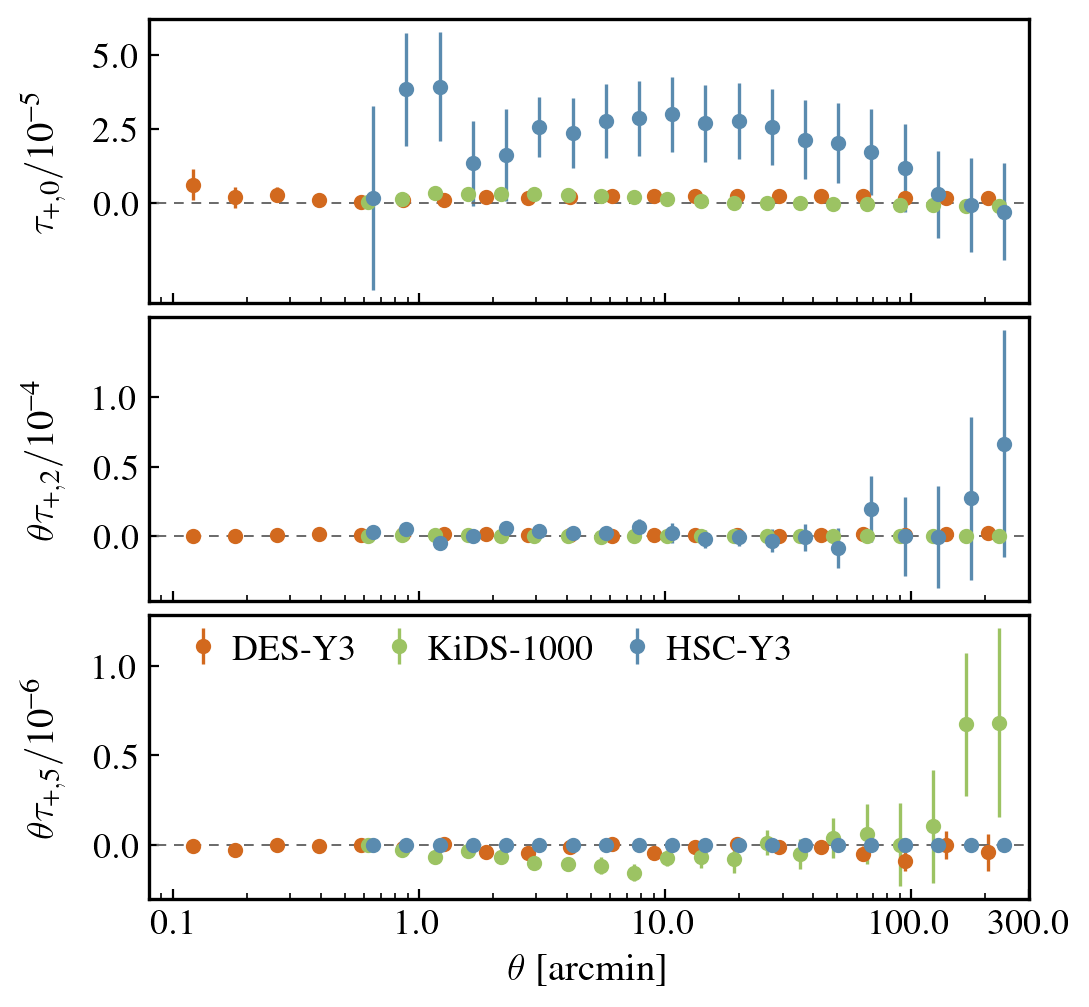

In [61]:
%matplotlib inline
matplotlib.rcParams.update({'font.size': 13})

# CHECK COVARIANCE INDICES AGAIN

plt.clf()
fig = plt.figure(figsize=(5.5,5),dpi=100)

gs  = gridspec.GridSpec(3, 1, top=0.98, right=0.96, left=0.16, bottom=0.1,hspace=0.05,wspace=0.15)

ax0 = plt.subplot(gs[0])
ax0.set_ylabel(r'$\tau_{+,0}/10^{-5}$',size=14,labelpad=10)
ax0.errorbar(10**(np.log10(des['tht'])+0.00) ,des['tau0']/1e-5   ,yerr=(np.diag(des['cov'])**0.5)[:20]/1e-5     ,marker='o',ls='None',ms=4.5,elinewidth=1.2,color=descol)
ax0.errorbar(10**(np.log10(kids['tht'])+0.02),kids['tau0']/1e-5  ,yerr=(np.diag(kids['cov'])**0.5)[:20]/1e-5    ,marker='o',ls='None',ms=4.5,elinewidth=1.2,color=kidscol)
ax0.errorbar(10**(np.log10(hsc['tht'])+0.04) ,hsc['tau0']/1e-5   ,yerr=(np.diag(hsc['cov'])**0.5)[:20]/1e-5 ,marker='o',ls='None',ms=4.5,elinewidth=1.2,color=hsccol)

ax0.semilogx(np.arange(300),np.zeros(300),color='dimgray',ls='--',lw=0.7,dashes=(5,4))
ax0.tick_params(axis="both",which='both',direction="in")
plt.setp(ax0.get_xticklabels(), visible=False)
#ax0.tick_params(axis="x",direction="in")
ax0.set_xlim(0.08,300)
ax0.set_yticks([0.0,2.5,5.0])

ax1 = plt.subplot(gs[1])

ax1.set_ylabel(r'$\theta\tau_{+,2}/10^{-4}$',size=14,labelpad=10)
ax1.errorbar(10**(np.log10(des['tht'])+0.00) ,des['tht']*des['tau2']/1e-4  ,yerr=des['tht']*(np.diag(des['cov'])**0.5)[40:60]/1e-4  ,marker='o',ls='None',ms=4.5,elinewidth=1.2,color=descol)
ax1.errorbar(10**(np.log10(kids['tht'])+0.02),kids['tht']*kids['tau2']/1e-4,yerr=kids['tht']*(np.diag(kids['cov'])**0.5)[20:40]/1e-4,marker='o',ls='None',ms=4.5,elinewidth=1.2,color=kidscol)
ax1.errorbar(10**(np.log10(hsc['tht'])+0.04) ,hsc['tht']*hsc['tau2']/1e-4  ,yerr=hsc['tht']*(np.diag(hsc['cov'])**0.5)[20:40]/1e-4  ,marker='o',ls='None',ms=4.5,elinewidth=1.2,color=hsccol)

ax1.semilogx(np.arange(300),np.zeros(300),color='dimgray',ls='--',lw=0.7,dashes=(5,4))
ax1.tick_params(axis="both",which='both',direction="in")
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_xlim(0.08,300)
ax1.set_yticks([0.0,0.5,1.0])

ax2 = plt.subplot(gs[2])
ax2.set_ylabel(r'$\theta\tau_{+,5}/10^{-6}$',size=14,labelpad=10)
ax2.errorbar(10**(np.log10(des['tht'])+0.00) ,des['tht']*des['tau5']/1e-6      ,yerr=des['tht']*(np.diag(des['cov'])**0.5)[80:100]/1e-6     ,marker='o',ls='None',ms=4.5,elinewidth=1.2,color=descol,label='DES-Y3')
ax2.errorbar(10**(np.log10(kids['tht'])+0.02),kids['tht']*kids['tau5']/1e-6,yerr=kids['tht']*(np.diag(kids['cov'])**0.5)[40:60]/1e-6,marker='o',ls='None',ms=4.5,elinewidth=1.2,color=kidscol,label='KiDS-1000')
ax2.errorbar(10**(np.log10(hsc['tht'])+0.04) ,hsc['tht']*hsc['tau5']/1e-6      ,yerr=hsc['tht']*(np.diag(hsc['cov'])**0.5)[40:60]/1e-6      ,marker='o',ls='None',ms=4.5,elinewidth=1.2,color=hsccol,label='HSC-Y3')

ax2.semilogx(np.arange(300),np.zeros(300),color='dimgray',ls='--',lw=0.7,dashes=(5,4))
ax2.tick_params(axis="both",which='both',direction="in")
ax2.set_xlabel(r'$\theta\ [{\rm arcmin}]$',size=14)
ax2.set_xlim(0.08,300)

ax2.get_xaxis().set_major_formatter(matplotlib.ticker.NullFormatter())
ax2.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax2.set_xticks([0.1,1,10,100,300])
ax2.legend(frameon=False,labelspacing=0.05,ncol=3,handletextpad=-0.2,columnspacing=0.2,loc='upper left',borderpad=0)
ax2.set_yticks([0.0,0.5,1.0])
from matplotlib.ticker import ScalarFormatter
for axis in [ax2.xaxis]:
    axis.set_major_formatter(ScalarFormatter())
    
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(1.2)
    ax1.spines[axis].set_linewidth(1.2)
    ax2.spines[axis].set_linewidth(1.2)
    
plt.savefig('/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/plots/taustats.pdf',dpi=200)


# B-modes

Data types:  ['galaxy_shear_cl_bb']
Tracer combinations:  [('source_0', 'source_0'), ('source_1', 'source_0'), ('source_1', 'source_1'), ('source_2', 'source_0'), ('source_2', 'source_1'), ('source_2', 'source_2'), ('source_3', 'source_0'), ('source_3', 'source_1'), ('source_3', 'source_2'), ('source_3', 'source_3')]
Size:  200


<Figure size 432x288 with 0 Axes>

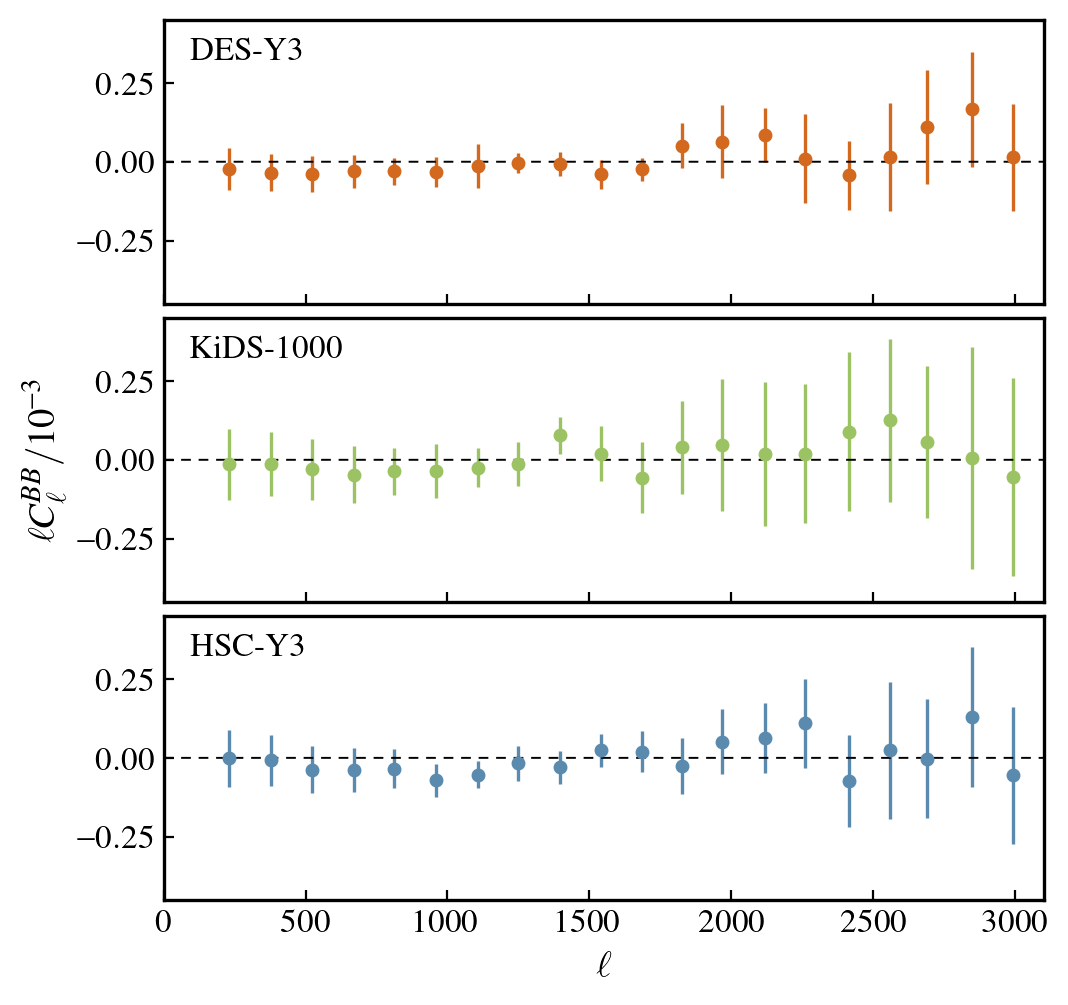

In [59]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import sacc

matplotlib.rcParams.update({'font.size': 12})


plt.clf()
fig = plt.figure(figsize=(5.5,5),dpi=100)

gs  = gridspec.GridSpec(3, 1, top=0.98, right=0.96, left=0.16, bottom=0.1,hspace=0.05,wspace=0.15)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])


s = sacc.Sacc.load_fits("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/txpipe/testbb/data/desy3a/outputs/twopoint_data_fourier_pureB.sacc")

data_types = np.unique([d.data_type for d in s.data])
print("Data types: ", data_types)
print("Tracer combinations: ", s.get_tracer_combinations())
print("Size: ", s.mean.size)

l, cl0, cov0 = s.get_ell_cl('galaxy_shear_cl_bb', 'source_0','source_0', return_cov=True)
l, cl1, cov1 = s.get_ell_cl('galaxy_shear_cl_bb', 'source_1','source_1', return_cov=True)
l, cl2, cov2 = s.get_ell_cl('galaxy_shear_cl_bb', 'source_2','source_2', return_cov=True)
l, cl3, cov3 = s.get_ell_cl('galaxy_shear_cl_bb', 'source_3','source_3', return_cov=True)

#ax0.errorbar(l,cl0,yerr=np.diag(cov0)**0.5,ls='None',marker='o',elinewidth=0.7,ms=4, color='dimgray')
#ax0.errorbar(l+20,cl1,yerr=np.diag(cov1)**0.5,ls='None',marker='^',elinewidth=0.7,ms=4, color='teal')
#ax0.errorbar(l+40,cl2,yerr=np.diag(cov2)**0.5,ls='None',marker='s',elinewidth=0.7,ms=4, color='chocolate')
ax0.errorbar(l+60,cl3/1e-3,yerr=np.diag(cov2)**0.5/1e-3,ls='None',marker='o',elinewidth=1.2,ms=4, color=descol)
ax0.plot(np.zeros(3100),'k--',lw=0.7,dashes=(5,4))
ax0.set_xlim(0,3100)
ax0.set_ylim(-0.45,0.45)
plt.setp(ax0.get_xticklabels(), visible=False)
ax0.tick_params(axis="both",which='both',direction="in")
ax0.text(0.03,0.94,r'${\rm DES\textnormal{-}Y3}$',ha='left',va='top',  transform=ax0.transAxes)


s = sacc.Sacc.load_fits("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/txpipe/testbb/data/kids/outputs/meansubperfield/twopoint_data_fourier_pureB.sacc")

l, cl0, cov0 = s.get_ell_cl('galaxy_shear_cl_bb', 'source_0','source_0', return_cov=True)
l, cl1, cov1 = s.get_ell_cl('galaxy_shear_cl_bb', 'source_1','source_1', return_cov=True)
l, cl2, cov2 = s.get_ell_cl('galaxy_shear_cl_bb', 'source_2','source_2', return_cov=True)
l, cl3, cov3 = s.get_ell_cl('galaxy_shear_cl_bb', 'source_3','source_3', return_cov=True)

ax1.errorbar(l+60,cl3/1e-3,yerr=np.diag(cov2)**0.5/1e-3,ls='None',marker='o',elinewidth=1.2,ms=4, color=kidscol)
ax1.plot(np.zeros(3100),'k--',lw=0.7,dashes=(5,4))
ax1.set_xlim(0,3100)
ax1.set_ylim(-0.45,0.45)
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.tick_params(axis="both",which='both',direction="in")
ax1.text(0.03,0.94,r'${\rm KiDS \textnormal{-} 1000}$',ha='left',va='top',  transform=ax1.transAxes)

ax1.set_ylabel(r"$\ell C_{\ell}^{BB}/10^{-3}$",size=14)

s = sacc.Sacc.load_fits("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/txpipe/testbb/data/hsc-y3/outputs//shearsys/twopoint_data_fourier_pureB.sacc")

l, cl0, cov0 = s.get_ell_cl('galaxy_shear_cl_bb', 'source_0','source_0', return_cov=True)
l, cl1, cov1 = s.get_ell_cl('galaxy_shear_cl_bb', 'source_1','source_1', return_cov=True)
l, cl2, cov2 = s.get_ell_cl('galaxy_shear_cl_bb', 'source_2','source_2', return_cov=True)
l, cl3, cov3 = s.get_ell_cl('galaxy_shear_cl_bb', 'source_3','source_3', return_cov=True)

ax2.errorbar(l+60,cl3/1e-3,yerr=np.diag(cov2)**0.5/1e-3,ls='None',marker='o',elinewidth=1.2,ms=4, color=hsccol)
ax2.plot(np.zeros(3100),'k--',lw=0.7,dashes=(5,4))
ax2.set_xlim(0,3100)
ax2.set_ylim(-0.45,0.45)
ax2.tick_params(axis="both",which='both',direction="in")
ax2.text(0.03,0.94,r'${\rm HSC}\textnormal{-}{\rm Y3}$',ha='left',va='top',  transform=ax2.transAxes)
ax2.set_xlabel(r"$\ell$",size=14)

for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(1.2)
    ax1.spines[axis].set_linewidth(1.2)
    ax2.spines[axis].set_linewidth(1.2)
    
plt.savefig('/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/plots/hybrideb.pdf',dpi=200)


In [9]:
cl0

array([ 3.06624502e-06, -8.52723566e-07,  2.32436930e-06,  5.53187750e-06,
        1.11678854e-05,  1.04665079e-05, -1.54868905e-05, -5.37118904e-06,
       -1.66210210e-05, -1.70415937e-05,  1.51167455e-05,  2.92687060e-05,
       -1.16021735e-05, -2.02930649e-05,  3.00610550e-05,  2.68269888e-05,
       -9.59989672e-06, -6.94359025e-05, -4.04805805e-05, -3.61102038e-05])

# Paper comparison plots

### DESY3

In [32]:
from astropy.io import fits
d=fits.open('/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/desy3/official/2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate.fits')

xip = {}
xim = {}

for i in range(1,5):
    for j in range(i,5):
        idx = np.where( (d['xip'].data['BIN1']==i) & (d['xip'].data['BIN2']==j) )[0]
        xip['%d-%d'%(i,j)] = {'ang': d['xip'].data['ang'][idx], 'value': d['xip'].data['value'][idx]}
        
for i in range(1,5):
    for j in range(i,5):
        idx = np.where( (d['xim'].data['BIN1']==i) & (d['xim'].data['BIN2']==j) )[0]
        xim['%d-%d'%(i,j)] = {'ang': d['xim'].data['ang'][idx], 'value': d['xim'].data['value'][idx]}

11m
12m
13m
14m
44p
22m
23m
24m
34p
33p
33m
34m
24p
23p
22p
44m
14p
13p
12p
11p


Text(0.98, 0.58, '$\\theta\\times\\xi_{-}(\\theta)$')

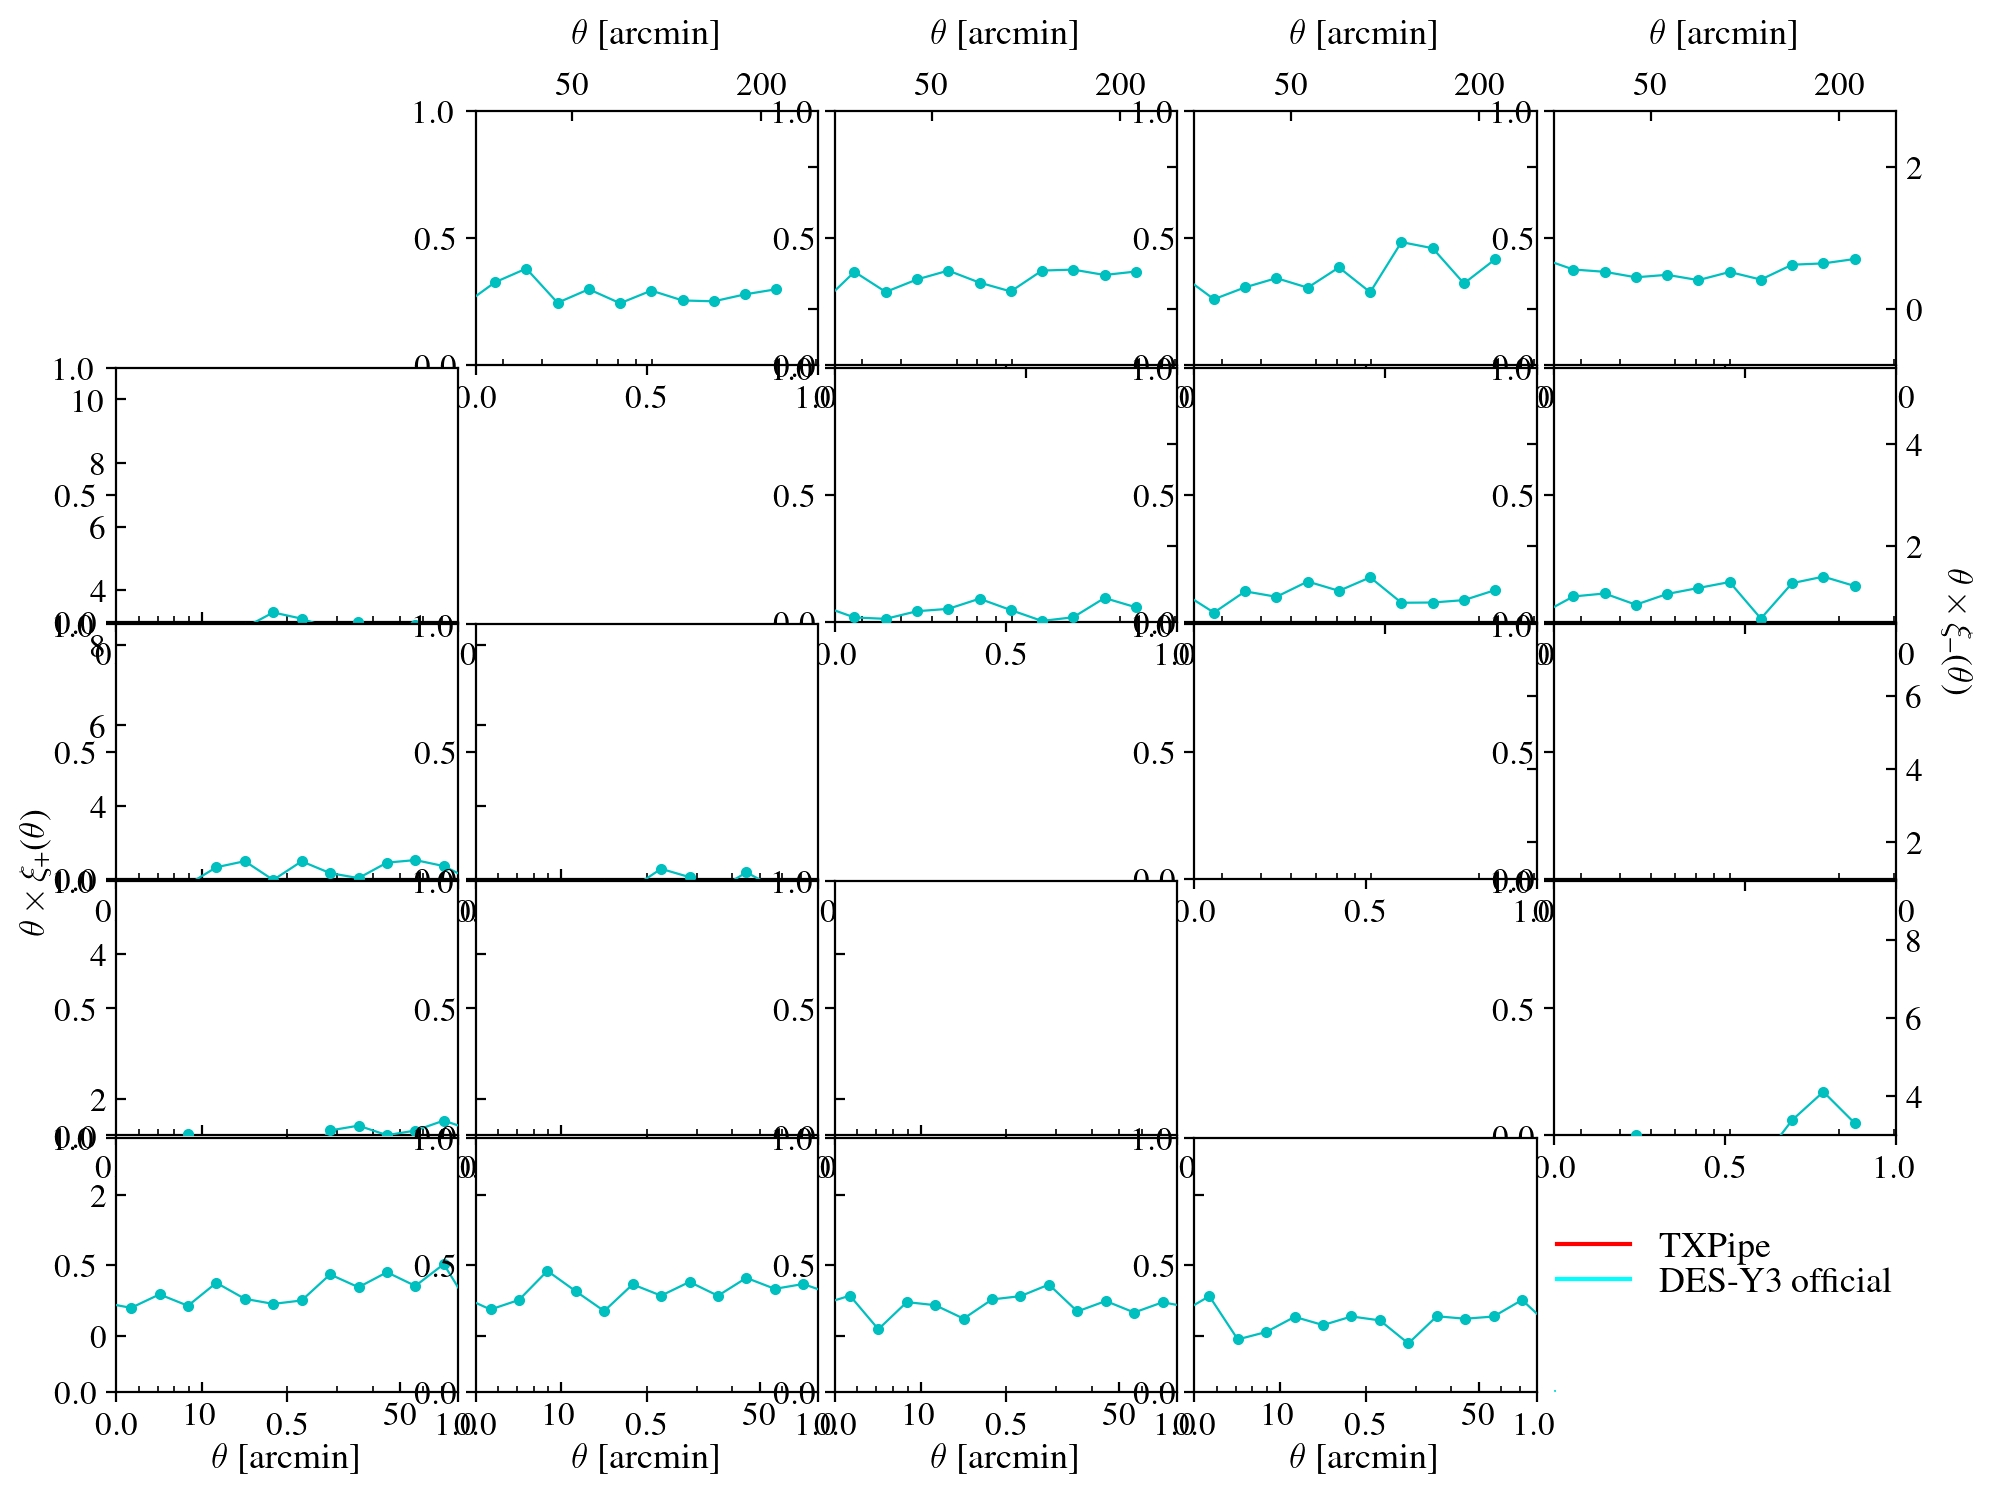

In [40]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec #import GridSpec
import sacc

matplotlib.rcParams.update({'font.size': 12})

dir = '/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/txpipe/hsc-y3/data/hsc-y3/outputs/shearsys/' #scaled coupled noise
a = sacc.Sacc.load_fits(dir + 'twopoint_data_real_raw.sacc')


img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xim11.png")

fig = plt.figure(figsize=(10,7.45),dpi=100,facecolor='w')


gs  = gridspec.GridSpec(5, 5,
                       #height_ratios=[4,1],
                       top=0.93,
                       bottom=0.07,
                       hspace=0.01,
                       wspace=0.05,
                       right=0.95,
                       left=0.06
                       )
plt.rcParams['axes.grid'] = False

order   = [None,'11m','12m','13m','14m',
          '44p',None ,'22m','23m','24m',
          '34p','33p',None ,'33m','34m',
          '24p','23p','22p',None ,'44m',
          '14p','13p','12p','11p',None
          ]


y = [1,1,1,1.1,1.]


c=0
for i in range(0,5):
    for j in range(0,5):
        ax = plt.subplot(gs[c])
        
        facm = y[i]*y[j]
        facp = y[4-i]*y[4-j]
    
        if order[c] is not None:
            #ax.imshow(img,  aspect='equal',alpha=0.5,extent=(24.5,305,-0.75,2.65))
            s=order[c][2]
            b1=int(order[c][0])-1
            b2=int(order[c][1])-1
            
            print(order[c])
            
            if i==0 and s=='m': 
                sign='minus'
                #img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xim%d%d.png"%(i+1,j))

                #ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                #ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                #newax.set_ylim(-0.8,2.8)
                newax.yaxis.tick_right()
                
                #ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                #val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                #newax.plot(ang[-8:],facm*ang[-8:]*val[-8:]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(24.5,305)
                
                newax.plot(xim['%d-%d'%(i+1,j)]['ang'],facm*xim['%d-%d'%(i+1,j)]['ang']*xim['%d-%d'%(i+1,j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                
                if j!=4: plt.setp(newax.get_yticklabels(), visible=False)
                newax.tick_params(axis="both",which='both',direction="in")
                newax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

                newax.get_xaxis().set_major_formatter(matplotlib.ticker.NullFormatter())
                newax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
                newax.set_xticks([50,200])

                from matplotlib.ticker import ScalarFormatter
                for axis in [newax.xaxis]:
                    axis.set_major_formatter(ScalarFormatter())
                    
                newax.set_xlabel(r"$\theta\ [{\rm arcmin}]$",size=13,labelpad=10)
                newax.tick_params(axis="both",which='both',direction="in")
                newax.xaxis.set_label_position('top')
                
            if i==1 and s=='m': 
                sign='minus'
                #img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xim%d%d.png"%(i+1,j))
                #ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                #ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                #newax.set_ylim(0.5,5.5)
                newax.yaxis.tick_right()
                
                #ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                #val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                #newax.plot(ang[-8:],facm*ang[-8:]*val[-8:]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(24.5,305)
                
                newax.plot(xim['%d-%d'%(i+1,j)]['ang'],facm*xim['%d-%d'%(i+1,j)]['ang']*xim['%d-%d'%(i+1,j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                plt.setp(newax.get_xticklabels(), visible=False)
                
                if j!=4: plt.setp(newax.get_yticklabels(), visible=False)
                newax.tick_params(axis="both",which='both',direction="in")
                newax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
                plt.setp(newax.get_xticklabels(), visible=False)
                
            if i==2 and s=='m': 
                sign='minus'
                #img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xim%d%d.png"%(i+1,j))
                #ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                #ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                #newax.set_ylim(1.0,7.95)
                newax.yaxis.tick_right()
                newax.set_yticks([2,4,6])
                
                #ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                #val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                #newax.plot(ang[-8:],facm*ang[-8:]*val[-8:]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(24.5,305)
                
                #newax.plot(xim['%d-%d'%(i+1,j)]['ang'],facm*xim['%d-%d'%(i+1,j)]['ang']*xim['%d-%d'%(i+1,j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                plt.setp(newax.get_xticklabels(), visible=False)
                
                if j!=4: plt.setp(newax.get_yticklabels(), visible=False)
                newax.tick_params(axis="both",which='both',direction="in")
                newax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
                plt.setp(newax.get_xticklabels(), visible=False)
                
            if i==3 and s=='m': 
                sign='minus'
                #img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xim%d%d.png"%(i+1,j))
                #ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                #ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                #newax.set_ylim(3.,9.5)
                newax.yaxis.tick_right()
                newax.set_yticks([4,6,8])
                
                #ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                #val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                #newax.plot(ang[-8:],facm*ang[-8:]*val[-8:]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(24.5,305)
                
                plt.setp(newax.get_xticklabels(), visible=False)
                newax.plot(xim['%d-%d'%(i+1,j)]['ang'],facm*xim['%d-%d'%(i+1,j)]['ang']*xim['%d-%d'%(i+1,j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                newax.tick_params(axis="both",which='both',direction="in")
                newax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
                plt.setp(newax.get_xticklabels(), visible=False)
                
  
            if i==1 and s=='p': 
                sign='plus'
                #img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xip%d%d.png"%(5-i,4-j))

                #ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                #ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                #newax.set_ylim(3,11)
                newax.set_yticks([4,6,8,10])
                #newax.yaxis.tick_right()
                
                #ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                #val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                #newax.plot(ang[:9],facp*ang[:9]*val[:9]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(5,80)
                
                newax.plot(xip['%d-%d'%(5-i,4-j)]['ang'],facm*xip['%d-%d'%(5-i,4-j)]['ang']*xip['%d-%d'%(5-i,4-j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                
                plt.setp(newax.get_xticklabels(), visible=False)
                if j!=0: plt.setp(newax.get_yticklabels(), visible=False)
                newax.tick_params(axis="both",which='both',direction="in")

                
            if i==2 and s=='p': 
                sign='plus'
                #img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xip%d%d.png"%(5-i,4-j))
                #ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                #ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                newax.set_ylim(2.2,8.5)
                newax.set_yticks([4,6,8])
                #newax.yaxis.tick_right()
                
                #ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                #val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                #newax.plot(ang[:9],facp*ang[:9]*val[:9]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(5,80)
                
                newax.plot(xip['%d-%d'%(5-i,4-j)]['ang'],facm*xip['%d-%d'%(5-i,4-j)]['ang']*xip['%d-%d'%(5-i,4-j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                
                plt.setp(newax.get_xticklabels(), visible=False)
                if j!=0: plt.setp(newax.get_yticklabels(), visible=False)
                newax.tick_params(axis="both",which='both',direction="in")

                
            if i==3 and s=='p': 
                sign='plus'
                #img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xip%d%d.png"%(5-i,4-j))
                #ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                #ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                newax.set_ylim(1.5,5)
                #newax.yaxis.tick_right()
                newax.set_yticks([2,4])
                
                #ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                #val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                #newax.plot(ang[:9],facp*ang[:9]*val[:9]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(5,80)
                
                newax.plot(xip['%d-%d'%(5-i,4-j)]['ang'],facm*xip['%d-%d'%(5-i,4-j)]['ang']*xip['%d-%d'%(5-i,4-j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                
                plt.setp(newax.get_xticklabels(), visible=False)
                if j!=0: plt.setp(newax.get_yticklabels(), visible=False)
                newax.tick_params(axis="both",which='both',direction="in")

                
            if i==4 and s=='p': 
                sign='plus'
                #img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xip%d%d.png"%(5-i,4-j))
                #ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                #ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                newax.set_ylim(-0.8,2.8)
                #newax.yaxis.tick_right()
                newax.set_yticks([0,2])
                
                #ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                #val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                #newax.plot(ang[:9],facp*ang[:9]*val[:9]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(5,80)
                
                newax.plot(xip['%d-%d'%(5-i,4-j)]['ang'],facm*xip['%d-%d'%(5-i,4-j)]['ang']*xip['%d-%d'%(5-i,4-j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                
                if j!=0: plt.setp(newax.get_yticklabels(), visible=False)
                
                newax.get_xaxis().set_major_formatter(matplotlib.ticker.NullFormatter())
                newax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
                newax.set_xticks([10,50])

                from matplotlib.ticker import ScalarFormatter
                for axis in [newax.xaxis]:
                    axis.set_major_formatter(ScalarFormatter())
                    
                newax.set_xlabel(r"$\theta\ [{\rm arcmin}]$",size=13 )
                newax.tick_params(axis="both",which='both',direction="in")


        else:
            ax.axis('off')
                
        #if i==0:
        #    plt.ylim(-0.75,2.65)
        #    print(ang[-8:]*val[-8:]*1e4)
           
        c+=1

ax = plt.subplot(gs[24])
ax.axis('off')
ax.plot(np.arange(10)*-100,color='r',label='TXPipe')
ax.plot(np.arange(10)*-100,color='cyan',label='DES-Y3 official')
#ax.plot(np.arange(10)*-100,color='#6774C6',label='DES-Y3 paper')


ax.set_ylim(0,2)
ax.set_xlim(0,2)
ax.legend(frameon=False,loc='center',fontsize=13,labelspacing=0.05)

newax.text(0.02, 0.42, r"$\theta\times\xi_{+}(\theta)$", transform=fig.transFigure,rotation=90,ha='center',va='center',size=13)
newax.text(0.98, 0.58, r"$\theta\times\xi_{-}(\theta)$", transform=fig.transFigure,rotation=270,ha='center',va='center',size=13)

#plt.savefig('/global/homes/y/yomori/hscy3_cosmicshear.pdf',dpi=200)

### KiDS-1000

### HSC-Y3

In [5]:
from astropy.io import fits
d=fits.open('/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/official/data_extend_all_cat0.fits')

d['xi_plus']

In [6]:
xip = {}
xim = {}

for i in range(1,5):
    for j in range(i,5):
        idx = np.where( (d['xi_plus'].data['BIN1']==i) & (d['xi_plus'].data['BIN2']==j) )[0]
        xip['%d-%d'%(i,j)] = {'ang': d['xi_plus'].data['ang'][idx], 'value': d['xi_plus'].data['value'][idx]}
        
for i in range(1,5):
    for j in range(i,5):
        idx = np.where( (d['xi_minus'].data['BIN1']==i) & (d['xi_minus'].data['BIN2']==j) )[0]
        xim['%d-%d'%(i,j)] = {'ang': d['xi_minus'].data['ang'][idx], 'value': d['xi_minus'].data['value'][idx]}

11m
12m
13m
14m
44p
22m
23m
24m
34p
33p
33m
34m
24p
23p
22p
44m
14p
13p
12p
11p


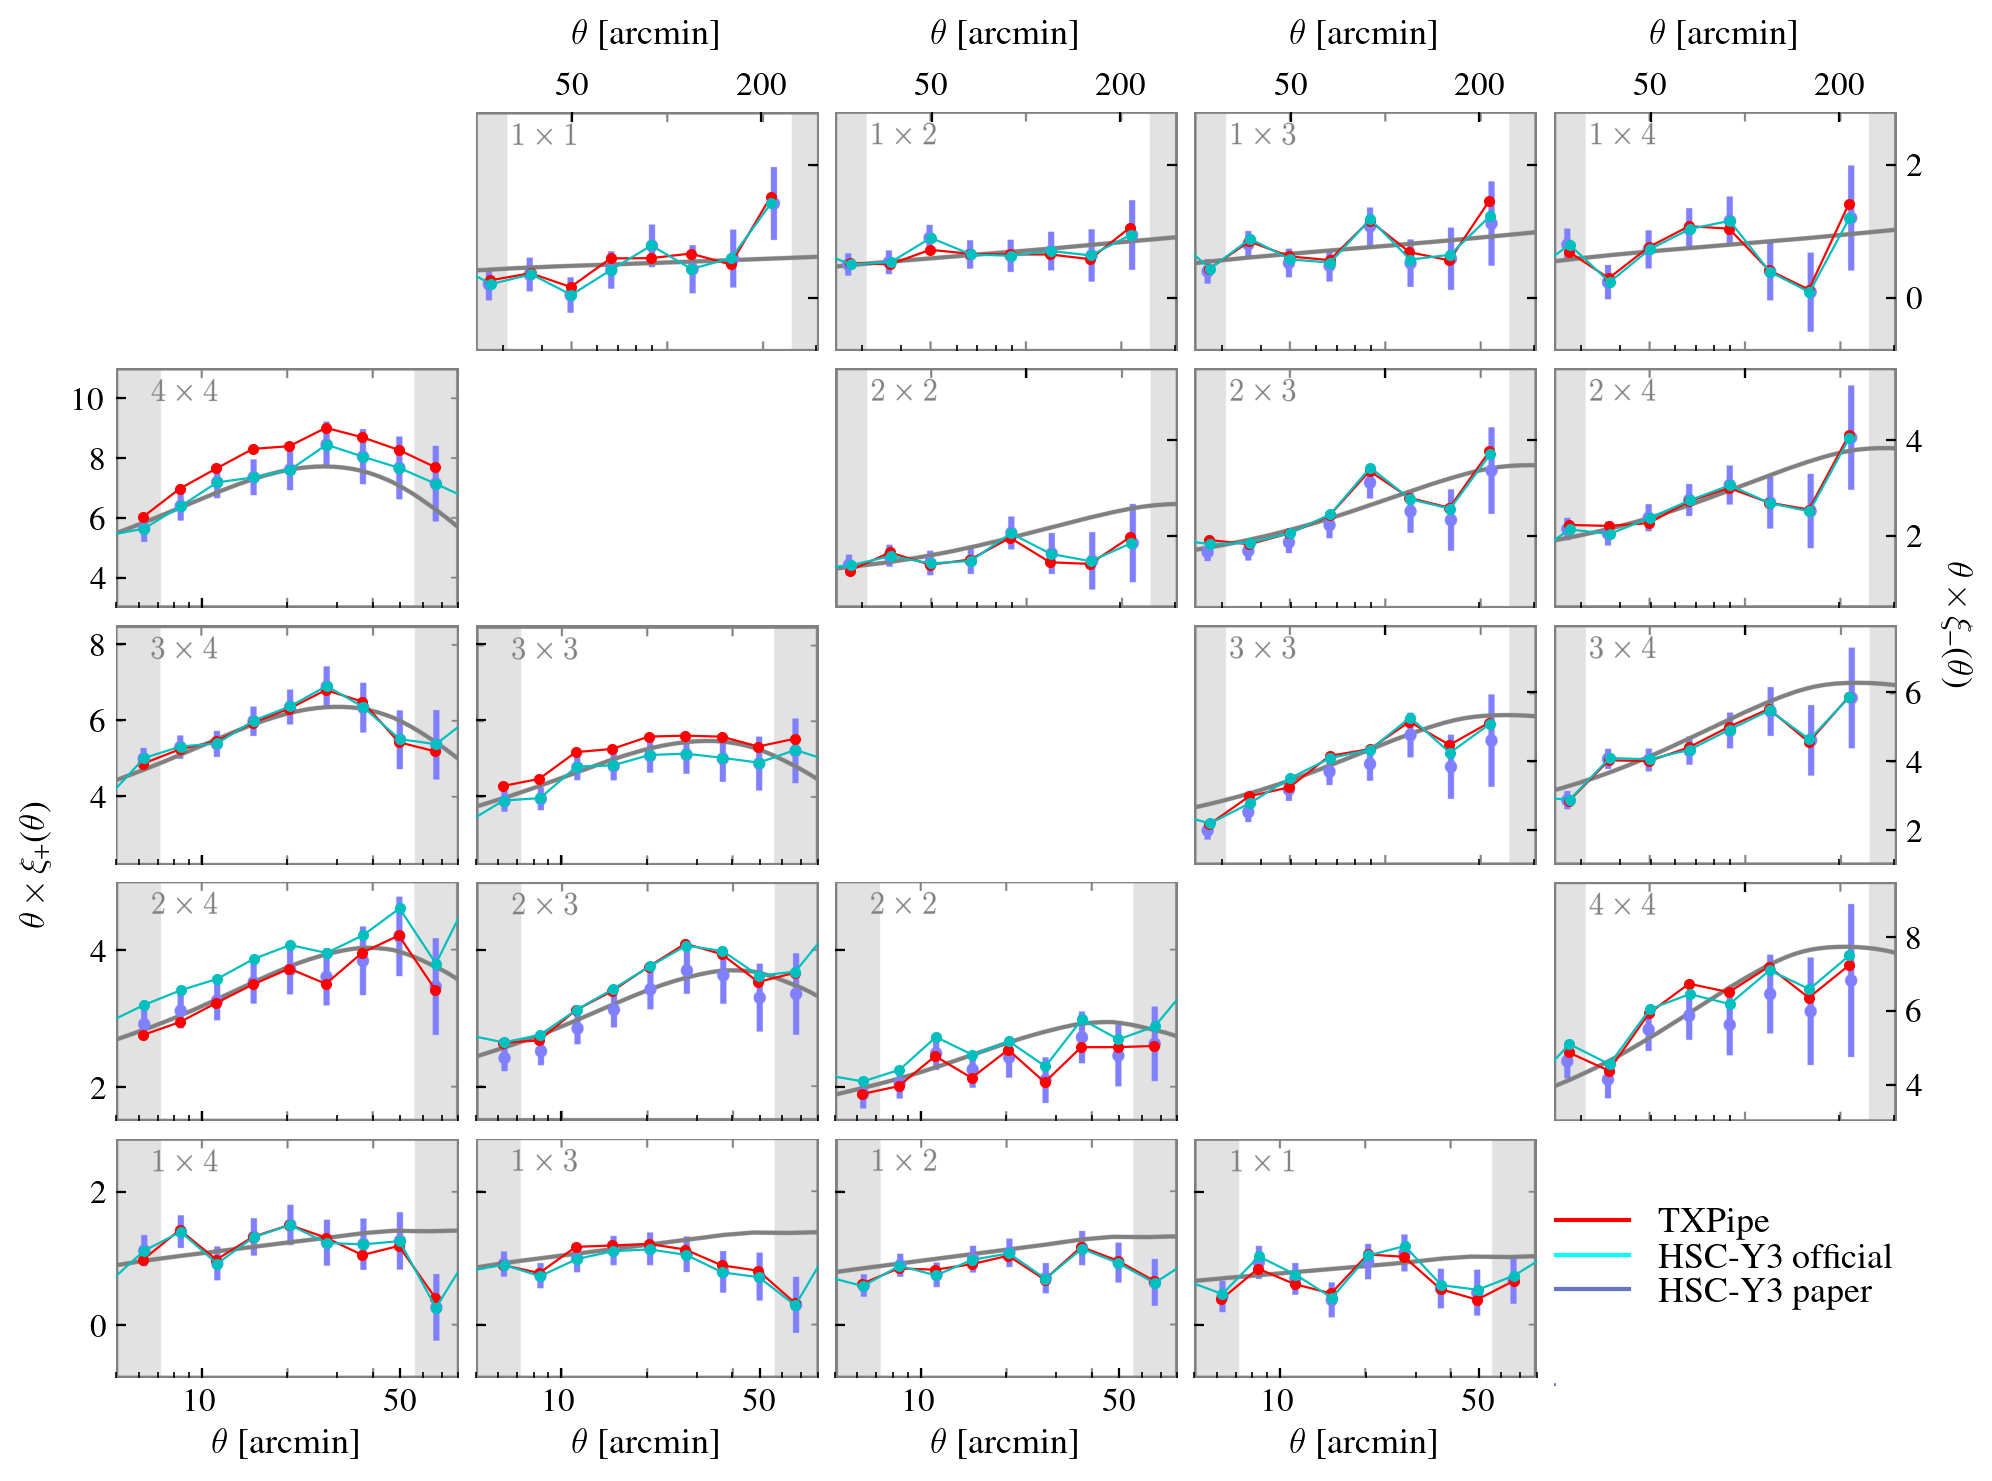

In [26]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec #import GridSpec
import sacc

matplotlib.rcParams.update({'font.size': 12})

dir = '/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/txpipe/hsc-y3/data/hsc-y3/outputs/shearsys/' #scaled coupled noise
a = sacc.Sacc.load_fits(dir + 'twopoint_data_real_raw.sacc')


img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xim11.png")

fig = plt.figure(figsize=(10,7.45),dpi=100,facecolor='w')


gs  = gridspec.GridSpec(5, 5,
                       #height_ratios=[4,1],
                       top=0.93,
                       bottom=0.07,
                       hspace=0.01,
                       wspace=0.05,
                       right=0.95,
                       left=0.06
                       )
plt.rcParams['axes.grid'] = False

order   = [None,'11m','12m','13m','14m',
          '44p',None ,'22m','23m','24m',
          '34p','33p',None ,'33m','34m',
          '24p','23p','22p',None ,'44m',
          '14p','13p','12p','11p',None
          ]


y = [1,1,1,1.1,1.]


c=0
for i in range(0,5):
    for j in range(0,5):
        ax = plt.subplot(gs[c])
        
        facm = y[i]*y[j]
        facp = y[4-i]*y[4-j]
    
        if order[c] is not None:
            #ax.imshow(img,  aspect='equal',alpha=0.5,extent=(24.5,305,-0.75,2.65))
            s=order[c][2]
            b1=int(order[c][0])-1
            b2=int(order[c][1])-1
            
            print(order[c])
            
            if i==0 and s=='m': 
                sign='minus'
                img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xim%d%d.png"%(i+1,j))

                ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                newax.set_ylim(-0.8,2.8)
                newax.yaxis.tick_right()
                
                ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                newax.plot(ang[-8:],facm*ang[-8:]*val[-8:]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(24.5,305)
                
                newax.plot(xim['%d-%d'%(i+1,j)]['ang'],facm*xim['%d-%d'%(i+1,j)]['ang']*xim['%d-%d'%(i+1,j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                
                if j!=4: plt.setp(newax.get_yticklabels(), visible=False)
                newax.tick_params(axis="both",which='both',direction="in")
                newax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

                newax.get_xaxis().set_major_formatter(matplotlib.ticker.NullFormatter())
                newax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
                newax.set_xticks([50,200])

                from matplotlib.ticker import ScalarFormatter
                for axis in [newax.xaxis]:
                    axis.set_major_formatter(ScalarFormatter())
                    
                newax.set_xlabel(r"$\theta\ [{\rm arcmin}]$",size=13,labelpad=10)
                newax.tick_params(axis="both",which='both',direction="in")
                newax.xaxis.set_label_position('top')
                
            if i==1 and s=='m': 
                sign='minus'
                img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xim%d%d.png"%(i+1,j))
                ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                newax.set_ylim(0.5,5.5)
                newax.yaxis.tick_right()
                
                ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                newax.plot(ang[-8:],facm*ang[-8:]*val[-8:]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(24.5,305)
                
                newax.plot(xim['%d-%d'%(i+1,j)]['ang'],facm*xim['%d-%d'%(i+1,j)]['ang']*xim['%d-%d'%(i+1,j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                plt.setp(newax.get_xticklabels(), visible=False)
                
                if j!=4: plt.setp(newax.get_yticklabels(), visible=False)
                newax.tick_params(axis="both",which='both',direction="in")
                newax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
                plt.setp(newax.get_xticklabels(), visible=False)
                
            if i==2 and s=='m': 
                sign='minus'
                img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xim%d%d.png"%(i+1,j))
                ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                newax.set_ylim(1.0,7.95)
                newax.yaxis.tick_right()
                newax.set_yticks([2,4,6])
                
                ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                newax.plot(ang[-8:],facm*ang[-8:]*val[-8:]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(24.5,305)
                
                newax.plot(xim['%d-%d'%(i+1,j)]['ang'],facm*xim['%d-%d'%(i+1,j)]['ang']*xim['%d-%d'%(i+1,j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                plt.setp(newax.get_xticklabels(), visible=False)
                
                if j!=4: plt.setp(newax.get_yticklabels(), visible=False)
                newax.tick_params(axis="both",which='both',direction="in")
                newax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
                plt.setp(newax.get_xticklabels(), visible=False)
                
            if i==3 and s=='m': 
                sign='minus'
                img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xim%d%d.png"%(i+1,j))
                ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                newax.set_ylim(3.,9.5)
                newax.yaxis.tick_right()
                newax.set_yticks([4,6,8])
                
                ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                newax.plot(ang[-8:],facm*ang[-8:]*val[-8:]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(24.5,305)
                
                plt.setp(newax.get_xticklabels(), visible=False)
                newax.plot(xim['%d-%d'%(i+1,j)]['ang'],facm*xim['%d-%d'%(i+1,j)]['ang']*xim['%d-%d'%(i+1,j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                newax.tick_params(axis="both",which='both',direction="in")
                newax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
                plt.setp(newax.get_xticklabels(), visible=False)
                
  
            if i==1 and s=='p': 
                sign='plus'
                img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xip%d%d.png"%(5-i,4-j))

                ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                newax.set_ylim(3,11)
                newax.set_yticks([4,6,8,10])
                #newax.yaxis.tick_right()
                
                ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                newax.plot(ang[:9],facp*ang[:9]*val[:9]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(5,80)
                
                newax.plot(xip['%d-%d'%(5-i,4-j)]['ang'],facm*xip['%d-%d'%(5-i,4-j)]['ang']*xip['%d-%d'%(5-i,4-j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                
                plt.setp(newax.get_xticklabels(), visible=False)
                if j!=0: plt.setp(newax.get_yticklabels(), visible=False)
                newax.tick_params(axis="both",which='both',direction="in")

                
            if i==2 and s=='p': 
                sign='plus'
                img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xip%d%d.png"%(5-i,4-j))
                ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                newax.set_ylim(2.2,8.5)
                newax.set_yticks([4,6,8])
                #newax.yaxis.tick_right()
                
                ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                newax.plot(ang[:9],facp*ang[:9]*val[:9]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(5,80)
                
                newax.plot(xip['%d-%d'%(5-i,4-j)]['ang'],facm*xip['%d-%d'%(5-i,4-j)]['ang']*xip['%d-%d'%(5-i,4-j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                
                plt.setp(newax.get_xticklabels(), visible=False)
                if j!=0: plt.setp(newax.get_yticklabels(), visible=False)
                newax.tick_params(axis="both",which='both',direction="in")

                
            if i==3 and s=='p': 
                sign='plus'
                img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xip%d%d.png"%(5-i,4-j))
                ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                newax.set_ylim(1.5,5)
                #newax.yaxis.tick_right()
                newax.set_yticks([2,4])
                
                ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                newax.plot(ang[:9],facp*ang[:9]*val[:9]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(5,80)
                
                newax.plot(xip['%d-%d'%(5-i,4-j)]['ang'],facm*xip['%d-%d'%(5-i,4-j)]['ang']*xip['%d-%d'%(5-i,4-j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                
                plt.setp(newax.get_xticklabels(), visible=False)
                if j!=0: plt.setp(newax.get_yticklabels(), visible=False)
                newax.tick_params(axis="both",which='both',direction="in")

                
            if i==4 and s=='p': 
                sign='plus'
                img = plt.imread("/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/hscy3/xip%d%d.png"%(5-i,4-j))
                ax.imshow(img, alpha=0.5,extent=(24.5,305,-0.75,2.65),aspect=(305-24.5)/(2.65+0.75)*0.7)
                ax.axis('off')
                newax = fig.add_axes(ax.get_position(), frameon=False)
                newax.set_ylim(-0.8,2.8)
                #newax.yaxis.tick_right()
                newax.set_yticks([0,2])
                
                ang=np.asarray(a.get_tag('theta', data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) ))
                val=a.get_mean(data_type="galaxy_shear_xi_%s"%sign, tracers=('source_%d'%b2,'source_%d'%b1) )
                newax.plot(ang[:9],facp*ang[:9]*val[:9]*1e4,marker='o',color='r',ms=3,lw=0.8)
                newax.semilogx()
                newax.set_xlim(5,80)
                
                newax.plot(xip['%d-%d'%(5-i,4-j)]['ang'],facm*xip['%d-%d'%(5-i,4-j)]['ang']*xip['%d-%d'%(5-i,4-j)]['value']*1e4,marker='o',color='c',ms=3,lw=0.8)
                
                if j!=0: plt.setp(newax.get_yticklabels(), visible=False)
                
                newax.get_xaxis().set_major_formatter(matplotlib.ticker.NullFormatter())
                newax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
                newax.set_xticks([10,50])

                from matplotlib.ticker import ScalarFormatter
                for axis in [newax.xaxis]:
                    axis.set_major_formatter(ScalarFormatter())
                    
                newax.set_xlabel(r"$\theta\ [{\rm arcmin}]$",size=13 )
                newax.tick_params(axis="both",which='both',direction="in")


        else:
            ax.axis('off')
                
        #if i==0:
        #    plt.ylim(-0.75,2.65)
        #    print(ang[-8:]*val[-8:]*1e4)
           
        c+=1

ax = plt.subplot(gs[24])
ax.axis('off')
ax.plot(np.arange(10)*-100,color='r',label='TXPipe')
ax.plot(np.arange(10)*-100,color='cyan',label='HSC-Y3 official')
ax.plot(np.arange(10)*-100,color='#6774C6',label='HSC-Y3 paper')


ax.set_ylim(0,2)
ax.set_xlim(0,2)
ax.legend(frameon=False,loc='center',fontsize=13,labelspacing=0.05)

newax.text(0.02, 0.42, r"$\theta\times\xi_{+}(\theta)$", transform=fig.transFigure,rotation=90,ha='center',va='center',size=13)
newax.text(0.98, 0.58, r"$\theta\times\xi_{-}(\theta)$", transform=fig.transFigure,rotation=270,ha='center',va='center',size=13)

plt.savefig('/global/homes/y/yomori/hscy3_cosmicshear.pdf',dpi=200)

In [4]:
import h5py

with h5py.File('/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/hsc-y3/shear/random_cats.hdf5', "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % f['randoms']['bin'].keys())
    # get first object name/key; may or may NOT be a group
    #list(f['randoms'].keys())[0]


AttributeError: 'Dataset' object has no attribute 'keys'